In [232]:
from preprocessing import *

# Load Data

In [233]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [234]:
DATASET_PATH = os.path.join('dataset')
actions = os.listdir(DATASET_PATH)
labels_map = {}

frames, labels_indexes, labels_text = [], [], []
for i, action in enumerate(actions):
    labels_map[action] = i
    for frame in os.listdir(os.path.join(DATASET_PATH, action)):
        data = np.load(os.path.join(DATASET_PATH, action, frame))
        if data.max() <= 0:
            continue
        frames.append(data)
        labels_text.append(action)
        labels_indexes.append(i)
        

frames = np.array(frames)
labels_text = np.array(labels_text)
labels_indexes = to_categorical(labels_indexes).astype(int)
frames_train, frames_test, labels_train, labels_test = train_test_split(frames, labels_indexes, test_size=.2, shuffle=True)

In [235]:
print(frames.shape, labels_indexes.shape)
print(frames_train.shape, frames_test.shape, labels_train.shape, labels_test.shape)

(783, 126) (783, 24)
(626, 126) (157, 126) (626, 24) (157, 24)


# Visualize the data

In [236]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt
import random

In [283]:
def landmarks_to_image(flattened_landmarks, offset=-0.3):
    image_shape = (480, 640, 3)
    background_image = np.zeros(image_shape, np.uint8)
    background_image[:] = (200, 200, 200)  # RGB value for white
    hand_landmarks_list = [flattened_landmarks[:21*3] + offset, flattened_landmarks[21*3:] + offset]
    annotated_image = np.copy(background_image)

    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=hand_landmarks[i], y=hand_landmarks[i+1], z=hand_landmarks[i+2]) 
            for i in range(0, len(hand_landmarks), 3)
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style()
        )

    return annotated_image

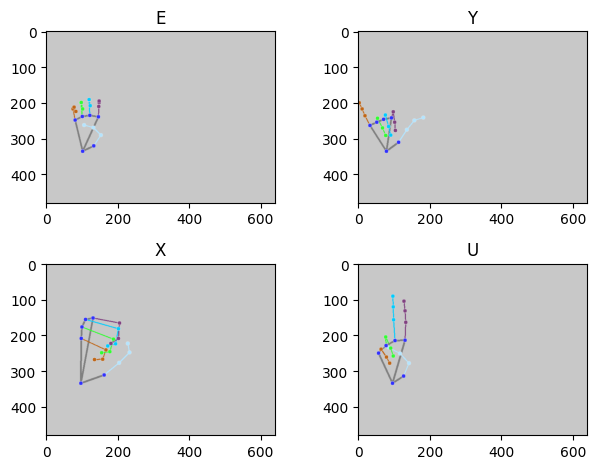

In [284]:
# Randomly sample 4 indices from each dataset
indices = random.sample(range(len(frames)), 4)
# Retrieve the images and labels
sampled_frames = [landmarks_to_image(frames[i], offset= -0.3) for i in indices]
sampled_labels = [labels_text[i] for i in indices]

fig, axes = plt.subplots(2, 2)
for i in range(4):
    axes.flatten()[i].imshow(sampled_frames[i])
    axes.flatten()[i].set_title(f'{sampled_labels[i].upper()}')
    # axes.flatten()[i].axis('off')
    
plt.tight_layout()

plt.show()

# Model the Neural Network

In [239]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras import callbacks

In [240]:
input_shape = (126,)
output_shape = (len(actions))

model = Sequential([
    layers.Input(input_shape),
    layers.Dense(128),
    layers.Dropout(0.2),
    layers.Dense(64),
    layers.Dropout(0.2),
    layers.Dense(16),
    layers.Dense(output_shape, activation='softmax')
])

In [241]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
        )
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 24)             │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,960 (101.41 KB)

 Trainable params: 25,960 (101.41 KB)

 Non-trainable params: 0 (0.00 B)

In [242]:
EPOCHS=100

earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=10,
                                        restore_best_weights=True)

history = model.fit(
  frames_train, labels_train,
  validation_data=(frames_test, labels_test),
  epochs=EPOCHS,
  callbacks=[earlystopping]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0318 - loss: 3.3253 - val_accuracy: 0.0446 - val_loss: 3.1684
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0922 - loss: 3.1086 - val_accuracy: 0.1911 - val_loss: 3.0005
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0840 - loss: 3.0050 - val_accuracy: 0.2102 - val_loss: 2.9222
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1347 - loss: 2.9885 - val_accuracy: 0.2611 - val_loss: 2.8517
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1560 - loss: 2.9156 - val_accuracy: 0.3185 - val_loss: 2.7338
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2355 - loss: 2.7511 - val_accuracy: 0.3248 - val_loss: 2.6197
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2624 - loss: 2.6358 - val_accuracy: 0.3121 - val_loss: 2.5385
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2788 - loss: 2.5898 - val_accuracy: 0.3376 - 

# Visualize training results

In [243]:
import pandas as pd
import matplotlib.pyplot as plt

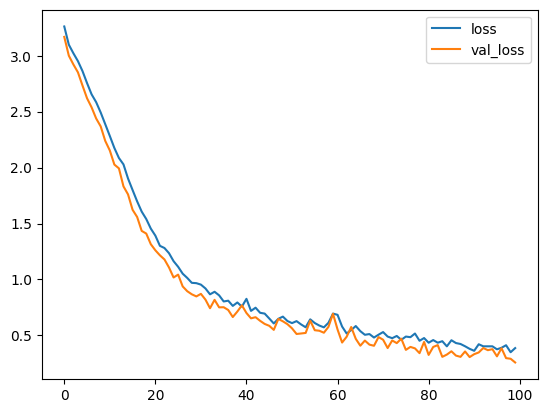

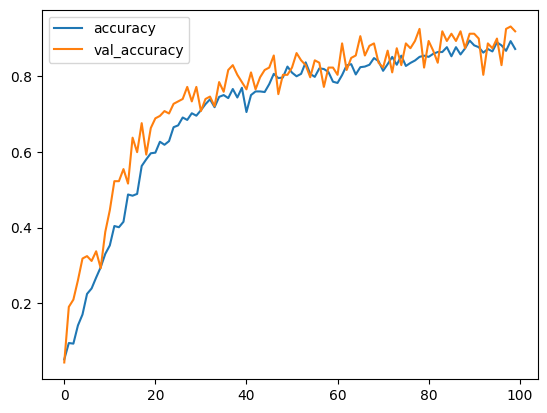

In [244]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [249]:
results = model.evaluate(frames_test, labels_test)
print("test loss, test acc:", results)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9138 - loss: 0.2405 
test loss, test acc: [0.2579284608364105, 0.9171974658966064]


# Predicting

In [257]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [268]:
labels_text

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c',
       'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c',
       'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c',
       'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd',
       'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd',
       'd', 'd', 'd', 'd', 'd', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e',
       'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e',
       'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'f', 'f', 'f',
       'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


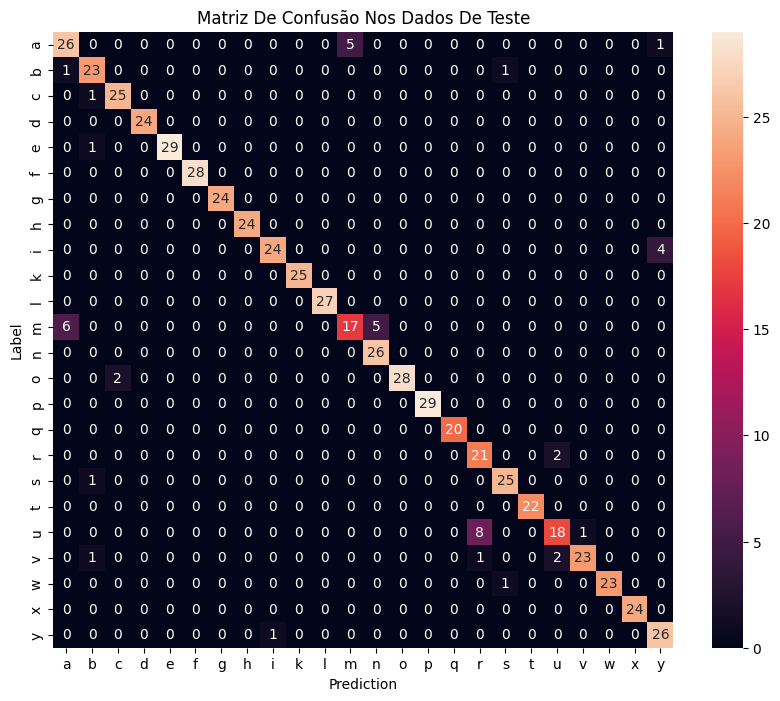

In [285]:
# Make predictions
predictions = model.predict(frames_train)

# Convert predictions and labels to class indices
predictions_class_indices = tf.argmax(predictions, axis=1)
labels_class_indices = tf.argmax(labels_train, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(labels_class_indices, predictions_class_indices)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=actions,
            yticklabels=actions,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Matriz de Confusão nos dados de teste".title())
plt.show()

# Saving Model

In [ ]:
import json


In [271]:
# Save the entire model as a `.keras` zip archive.
model.save(os.path.join('models', 'model.keras'))
# Save the labels to a JSON file
with open('labels.json', 'w') as f:
    json.dump(actions, f)

# Testing

In [ ]:
data = np.load(os.path.join(DATASET_PATH, "a", "0a96a8eb-0313-457d-8ff2-4ee0c6ece395.npy"))

In [ ]:
result = model.predict(np.array([data])).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
actions[result.argmax()]

'i'